# CLV - Markov Chain Example

In [66]:
import numpy as np
import random as rm

import pandas as pd
import matplotlib.pyplot as plt 
from numpy.linalg import inv

# Import the MarkovChain class from markovchain.py
import os
import sys

pd.set_option('display.float_format', lambda x: '%.5f' % x)



In [42]:
## node class
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

class Node():

    def __init__(
        self, center, radius, label,
        facecolor='#2693de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3'
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]

        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor

        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03

        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': 16
        }


    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle],
            edgecolor = self.node_edgecolor,
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label,
            xy = self.center,
            color = '#ffffff',
            **self.text_args
        )


    def add_self_loop(self, ax, prob=None, direction='up'):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15

        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y),
            self.radius,
            start,
            angle,
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow],
            edgecolor = self.ring_edgecolor,
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        if prob:
            ax.annotate(str(prob), xy=(self.x, prob_y), color='#000000', **self.text_args)


# markov class

In [43]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# module from this repository
from node import Node

class MarkovChain:

    def __init__(self, M, labels):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
        """

        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] > 4:
            raise Exception("Only works with 4 states max for now")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        # Colors
        self.arrow_facecolor = '#a3a3a3'
        self.arrow_edgecolor = '#a3a3a3'

        self.node_facecolor = '#2693de'
        self.node_edgecolor = '#e6e6e6'

        # Drawing config
        self.node_radius = 0.5
        self.arrow_width = 0.03
        self.arrow_head_width = 0.20
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': 16
        }

        # Build the network
        self.build_network()


    def set_node_centers(self):
        """
        Positions the node centers given the number of states
        """
        # Node positions
        self.node_centers = []

        if self.n_states == 2:
            self.figsize = (10, 4)
            self.xlim = (-5, 5)
            self.ylim = (-2, 2)
            self.node_centers = [[-4,0], [4,0]]
        elif self.n_states == 3:
            self.figsize = (10, 6)
            self.xlim = (-5, 5)
            self.ylim = (-3, 3)
            self.node_centers = [[-3,-2], [3,-2], [-3,2]]
        elif self.n_states == 4:
            self.figsize = (8, 8)
            self.xlim = (-5, 5)
            self.ylim = (-5, 5)
            self.node_centers = [[-4,4], [4,4], [4,-4], [-4,-4]]


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = []
        for i in range(self.n_states):
            node = Node(
                self.node_centers[i],
                self.node_radius,
                self.labels[i]
            )
            self.nodes.append(node)


    def add_arrow(self, ax, node1, node2, prob=None):
        """
        Add a directed arrow between two nodes
        """
        # x,y start of the arrow
        x_start = node1.x + np.sign(node2.x-node1.x) * node1.radius
        y_start = node1.y + np.sign(node2.y-node1.y) * node1.radius

        # arrow length
        dx = abs(node1.x - node2.x) - 2.5* node1.radius
        dy = abs(node1.y - node2.y) - 2.5* node1.radius

        # we don't want xoffset and yoffset to both be non-nul
        yoffset = 0.4 * self.node_radius * np.sign(node2.x-node1.x)
        if yoffset == 0:
            xoffset = 0.4 * self.node_radius * np.sign(node2.y-node1.y)
        else:
            xoffset = 0

        arrow = mpatches.FancyArrow(
            x_start + xoffset,
            y_start + yoffset,
            dx * np.sign(node2.x-node1.x),
            dy * np.sign(node2.y-node1.y),
            width = self.arrow_width,
            head_width = self.arrow_head_width
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        x_prob = x_start + xoffset + 0.2*dx*np.sign(node2.x-node1.x)
        y_prob = y_start + yoffset + 0.2*dy*np.sign(node2.y-node1.y)
        if prob:
            ax.annotate(str(prob), xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j:
                    # Loop direction
                    if self.nodes[i].y >= 0:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='up')
                    else:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='down')
                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax, self.nodes[i], self.nodes[j], prob = self.M[i,j])

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()


In [44]:
#p1=0.8, p2=0.4, p3=0.1
stateNames = ["Recent","TwoPlusMonths","ThreeMonths", "FourPlus"]


In [84]:
tMatrix = np.array([
    [0.8, 0.2, 0, 0],
    [0.6, 0.4, 0, 0],
    [0.5, 0, 0, 0.5],
    [0.25, 0, 0, .75]
])
tMatrix

array([[0.8 , 0.2 , 0.  , 0.  ],
       [0.6 , 0.4 , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.5 ],
       [0.25, 0.  , 0.  , 0.75]])

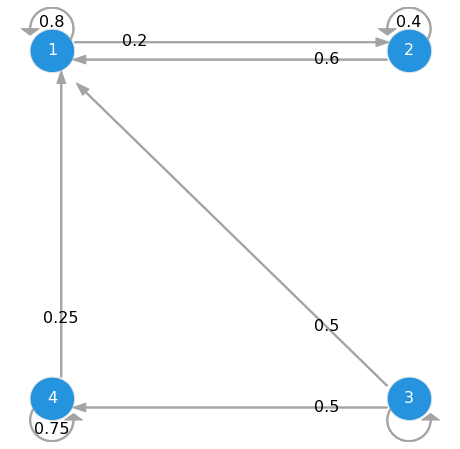

In [85]:
mc = MarkovChain(tMatrix, ['1', '2', '3', '4'])
mc.draw("/Users/mm679j/Documents/2022-MMA831-Python/markov-chain-four-states.png")


In [49]:
#Recall that the migration model formula for CLV is:
 
def get_clv(df_final, tran_mat, value_vector, d):
    """calculate clv using migration model formula and combine with the state calculate using function get_transition"""
    
    clv = np.dot(inv(np.identity(4) - tran_mat/(1+d)), value_vector)
    df_clv = pd.DataFrame(np.transpose(clv))
    df_clv['state'] = df_final['state']
    df_clv = df_clv.rename(columns = {0: 'CLV'})[['state', 'CLV']]
    
    return df_clv

In [52]:
initial_vector = np.array([1000,1000,1000,1000])


In [60]:
value_vector = np.array([40,30,10,3])


data = {'state':["Recent","TwoPlusMonths","ThreeMonths", "FourPlus"],
        'cust_cnt': [1000,1000,1000,1000],
        'state_value': [40, 30, 10, 3]
        }

df_final = pd.DataFrame(data)

df_final

,state,cust_cnt,state_value
0,Recent,1000,40
1,TwoPlusMonths,1000,30
2,ThreeMonths,1000,10
3,FourPlus,1000,3


In [ ]:
df_final

In [63]:
df_clv1 = get_clv(df_final, tMatrix, value_vector, d=0.1)
df_clv1

,state,CLV
0,Recent,420.000000
1,TwoPlusMonths,410.000000
2,ThreeMonths,341.558442
3,FourPlus,309.428571


In [78]:
#let's say we want to forecast 5 periods into the future
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(suppress=True)


p5_prob = np.power(tMatrix, 5)
p5_prob


array([[0.32768   , 0.00032   , 0.        , 0.        ],
       [0.32768   , 0.00032   , 0.        , 0.        ],
       [0.03125   , 0.        , 0.        , 0.03125   ],
       [0.00097656, 0.        , 0.        , 0.23730469]])

In [79]:
 np.power(tMatrix, 1)

array([[0.8 , 0.2 , 0.  , 0.  ],
       [0.8 , 0.2 , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.5 ],
       [0.25, 0.  , 0.  , 0.75]])

In [80]:
np.power(tMatrix, 2)

array([[0.64  , 0.04  , 0.    , 0.    ],
       [0.64  , 0.04  , 0.    , 0.    ],
       [0.25  , 0.    , 0.    , 0.25  ],
       [0.0625, 0.    , 0.    , 0.5625]])

In [81]:
np.power(tMatrix, 3)

array([[0.512   , 0.008   , 0.      , 0.      ],
       [0.512   , 0.008   , 0.      , 0.      ],
       [0.125   , 0.      , 0.      , 0.125   ],
       [0.015625, 0.      , 0.      , 0.421875]])

In [82]:
np.power(tMatrix, 20)

array([[0.01152922, 0.        , 0.        , 0.        ],
       [0.01152922, 0.        , 0.        , 0.        ],
       [0.00000095, 0.        , 0.        , 0.00000095],
       [0.        , 0.        , 0.        , 0.00317121]])

In [83]:
np.power(tMatrix, 30)

array([[0.00123794, 0.        , 0.        , 0.        ],
       [0.00123794, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00017858]])

In [ ]:
#let's say we want to forecast 5 periods into the future

p5_clv = np.power(tMatrix, 5)*value_vector
p5_clv

pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(suppress=True)

p5_clv
